## RNA-seq Data Analysis with SpliSER

Here I parse RNA-seq data from Mazin _et al._ to process it with SpliSER, and inspect the results.

## Data Processing for SpliSER

First, make an enviroment for processing the RNA data with SpliSER:

```bash
# conda env
conda create -n spliser python=3.10 -y
conda activate spliser
conda install -c bioconda pysam -y
conda install -c conda-forge ipykernel -y
python -m ipykernel install --user --name=spliser 
git clone -b speedups https://github.com/CraigIDent/SpliSER.git
cd SpliSER
pip install -e . --config-settings editable_mode=compat
```

To preprocess data, I use Splicevo environment.

I will run SpliSER for all samples from Mazin _et al_ - the bam files for all samples are listed in `samples_.txt`. First I will link the samples with metadata (from supplementary table 2 of Cardoso-Moreira et al.) and group replicates of the samples corresponding to the same time point and tissue/organ.

In [ ]:
import pandas as pd
from pathlib import Path

# Get current directory
wdir = Path().resolve()

# Project directory
project_dir = wdir.parent

# Load list of samples bam files
samples=pd.read_csv(Path(project_dir/ "data" / "spliser" / "bams.txt"),delimiter="\t")
# Create mock Timepoint column
samples["Timepoint"] = ""
# Create mock Group
samples["Group"] = samples["Species"] + '.' + samples["Organ_group"] + '.' + samples["Timepoint"]

# Load supplementary table with metadata
esm = pd.read_csv("ESM_Table_2.csv", delimiter=",")

# Merge by Library column
merged = pd.merge(samples, esm, on="Library", how="inner")

# Reorder columns
first_cols = ['Library', 'Species', 'Species_strain', 'Species_scientific_name', 'Organ_detail', 'Organ_group', 'Developmental_stage', 'Stage_detail', 'Timepoint', 'Group', 'Sex']
other_cols = [col for col in merged.columns if col not in first_cols]
cols = first_cols + other_cols
merged = merged[cols]


To map the samples with their developmental stages metadata to a aligned timepoints across developent, I will create a dictionary mapping each species' individual developmental stages to a common timepoint label (based on Extended Data Fig. 1 from Mazin et al.):

In [ ]:
timepoint_mapping = {
    'Human' : {
        '4wpc' : '1',
        '5wpc' : '2',
        '6wpc' : '3',
        '7wpc' : '4',
        '8wpc' : '5',
        '9wpc' : '6',
        '10wpc' : '6',
        '11wpc' : '6',
        '12wpc' : '7',
        '13wpc' : '8',
        '16wpc' : '9',
        '18wpc' : '10',
        '19wpc' : '10',
        '20wpc' : '11',
        'newborn' : '12',
        'infant' : '12',
        'toddler' : '12',
        'school': '13',
        'youngTeenager': '13',
        'teenager': '13',
        'oldTeenager' : '13',
        'youngAdult' : '13',
        'youngMidAge' : '14',
        'olderMidAge' : '14',
        'senior' : '15'
    },
    'Mouse' : {
        'e10.5' : '1',
        'e11.5' : '2',
        'e12.5' : '3',
        'e13.5' : '4',
        'e14.5' : '5',
        'e15.5' : '6',
        'e16.5' : '7',
        'e17.5' : '8',
        'e18.5' : '9',
        'P0' : '10',
        'P3' : '11',
        'P14' : '12',
        'P28' : '13',
        'P63' : '14'
    },
    'Macaque' : {
        'e93' : '10',
        'e109' : '10',
        'e112' : '11',
        'e113' : '11',
        'e123' : '11',
        'e130' : '11',
        'P0' : '12',
        '24 days post birth' : '12',
        'P6m' : '13',
        'P1y' : '14',
        'P3y' : '14',
        'P8y' : '14',
        'P9y' : '14',
        'P14-15y' : '15',
        'P20-26y' : '15',
        'P22-26y' : '15'
    },
    'Rat' : {
        'e11' : '1',
        'e12' : '2',
        'e13' : '3',
        'e14' : '3',
        'e15' : '4',
        'e16' : '5',
        'e17' : '6',
        'e18' : '7',
        'e19' : '8',
        'e20' : '9',
        'P0' : '10',
        'P3' : '11',
        'P7' : '12',
        'P14' : '12',
        'P42' : '13',
        'P112' : '14'
    }
}

Add timepoint info to metadata.

In [ ]:
# Add timepoint info to metadata
merged['Timepoint'] = merged.apply(lambda row: timepoint_mapping[row['Species']][row['Developmental_stage']] if row['Species'] in timepoint_mapping and row['Developmental_stage'] in timepoint_mapping[row['Species']] else row['Timepoint'], axis=1)
# Create Group column again
merged["Group"] = merged["Species"] + '.' + merged["Organ_group"] + '.' + merged["Timepoint"]
# Save
merged.to_csv("../data/spliser/samples.txt", sep="\t", index=False)

I will then run SpliSER on the helix cluster. I will create a job array for each species (modifying job submission script `scripts/spliser_job.sh` as needed to match species and nuber of groups i.e. jobs in an array). The paths to files to be processed and outputs to be saved are in the `scripts/spliser.sh`.

```bash
sbatch scripts/spliser_job.sh
```

SpliSER output files use `chr` notation, while the genome uses just numbers for chromosomes. I need to remove the `chr` prefix from the SpliSER usage files. I copy them from sds to `results/spliser` and process as shown below.

In [ ]:
usage_file="Mouse.Cerebellum.4wpb.combined.tsv"
awk -v OFS="\t" 'NR==1{print; next} {
    split($0, a, "\t");
    sub(/^chr/, "", a[2]);
    $0 = "";
    for (i=1; i<=length(a); i++) {
        printf "%s%s", a[i], (i==length(a) ? ORS : OFS);
    }
}' "$usage_file" > "${usage_file%.tsv}.nochr.tsv"
awk -F'\t' 'NR==1{n=NF; next} NF!=n{print "Line " NR ": " NF " fields"}' "${usage_file%.tsv}.nochr.tsv"

## SpliSER results

For this part, use SplicEvo enviroment because I need some of the IO functions from there.

### Overlap between splice sites with SpliSER usage info and annotated exon boundaries

Select the sample to inspect.

In [1]:
import pandas as pd
from pathlib import Path

# Get current directory
wdir = Path().resolve()

# Project directory
project_dir = wdir.parent

In [ ]:
from splicevo.io.gene_annotation import GTFProcessor

# Load gtf
annotation = 'mazin'
if annotation=='mazin':
    gtf_path="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz"
elif annotation=='gencode':
    gtf_path="/home/elek/sds/sd17d003/Anamaria/genomes/gencode/gtf/Homo_sapiens.gtf.gz"
gtf = GTFProcessor(gtf_path)

# Subset chromosomes
test_chr = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','X','Y','MT']
if annotation == 'gencode':
    test_chr = ["chr" + x for x in test_chr]
gtf_df = gtf.load_gtf(chromosomes=test_chr)
gtf_df

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading GTF file...
Loaded 4045835 GTF records


,chrom,source,feature,start,end,score,strand,frame,gene_id,transcript_id,exon_number
0,1,StringTie,transcript,11610,14412,1000,+,.,hum.1,hum.1.1,NaN
1,1,StringTie,exon,11610,12227,1000,+,.,hum.1,hum.1.1,1
2,1,StringTie,exon,12613,14412,1000,+,.,hum.1,hum.1.1,2
3,1,StringTie,transcript,14333,29442,1000,-,.,hum.2,hum.2.1,NaN
4,1,StringTie,exon,14333,15038,1000,-,.,hum.2,hum.2.1,1
...,...,...,...,...,...,...,...,...,...,...,...
4045830,Y,StringTie,exon,21907085,21907512,1000,+,.,hum.69702,hum.69702.1,1
4045831,Y,StringTie,transcript,21917601,21917890,1000,+,.,hum.69703,hum.69703.1,NaN
4045832,Y,StringTie,exon,21917601,21917890,1000,+,.,hum.69703,hum.69703.1,1
4045833,Y,StringTie,transcript,21918450,21929537,1000,+,.,hum.69704,hum.69704.1,NaN


In [ ]:
from splicevo.io.gene_annotation import GTFProcessor

# Load gtf
annotation = 'mazin'
if annotation=='mazin':
    gtf_path="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Mus_musculus.gtf.gz"
elif annotation=='gencode':
    gtf_path="/home/elek/sds/sd17d003/Anamaria/genomes/gencode/gtf/Mus_musculus.gtf.gz"
gtf = GTFProcessor(gtf_path)

# Subset chromosomes
test_chr = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','X','Y','MT']
if annotation == 'gencode':
    test_chr = ["chr" + x for x in test_chr]
gtf_df = gtf.load_gtf(chromosomes=test_chr)
gtf_df

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading GTF file...
Loaded 2796045 GTF records


,chrom,source,feature,start,end,score,strand,frame,gene_id,transcript_id,exon_number
0,1,StringTie,transcript,3057717,3057999,1000,+,.,mou.1,mou.1.1,NaN
1,1,StringTie,exon,3057717,3057999,1000,+,.,mou.1,mou.1.1,1
2,1,StringTie,transcript,3151276,3151544,1000,+,.,mou.2,mou.2.1,NaN
3,1,StringTie,exon,3151276,3151544,1000,+,.,mou.2,mou.2.1,1
4,1,StringTie,transcript,3152097,3154131,1000,+,.,mou.3,mou.3.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2796040,Y,StringTie,exon,90819087,90819147,1000,+,.,mou.50219,mou.50219.1,1
2796041,Y,StringTie,exon,90825085,90825225,1000,+,.,mou.50219,mou.50219.1,2
2796042,Y,StringTie,transcript,90826576,90828540,1000,-,.,mou.50220,mou.50220.1,NaN
2796043,Y,StringTie,exon,90826576,90826783,1000,-,.,mou.50220,mou.50220.1,1


In [2]:
from splicevo.io.gene_annotation import GTFProcessor

# Load gtf
annotation = 'mazin'
if annotation=='mazin':
    gtf_path="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Rattus_norvegicus.gtf.gz"
elif annotation=='gencode':
    gtf_path="/home/elek/sds/sd17d003/Anamaria/genomes/gencode/gtf/Rattus_norvegicus.gtf.gz"
gtf = GTFProcessor(gtf_path)

# Subset chromosomes
test_chr = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','X','MT']
if annotation == 'gencode':
    test_chr = ["chr" + x for x in test_chr]
gtf_df = gtf.load_gtf(chromosomes=test_chr)
gtf_df

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading GTF file...
Loaded 2540584 GTF records


,chrom,source,feature,start,end,score,strand,frame,gene_id,transcript_id,exon_number
0,1,StringTie,transcript,670181,670448,1000,-,.,rat.1,rat.1.1,NaN
1,1,StringTie,exon,670181,670448,1000,-,.,rat.1,rat.1.1,1
2,1,StringTie,transcript,728645,728894,1000,+,.,rat.2,rat.2.1,NaN
3,1,StringTie,exon,728645,728894,1000,+,.,rat.2,rat.2.1,1
4,1,StringTie,transcript,855987,856221,1000,+,.,rat.3,rat.3.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2540579,X,StringTie,exon,154516783,154516901,1000,-,.,rat.42864,rat.42864.35,9
2540580,X,StringTie,exon,154517698,154517786,1000,-,.,rat.42864,rat.42864.35,10
2540581,X,StringTie,transcript,154515032,154515746,1000,+,.,rat.42865,rat.42865.1,NaN
2540582,X,StringTie,exon,154515032,154515155,1000,+,.,rat.42865,rat.42865.1,1


Load SpliSER introns file.

In [3]:
# Sample
species = "Rattus_norvegicus"
name = "Rat"
tissue = "Brain"
group = "1"

# Introns file
filename = Path(project_dir, "results", "spliser", species, f"{name}.{tissue}.{group}.introns.tsv")
print(filename)

introns_df = pd.read_csv(filename, sep="\t", header=None, names=["chrom", "start", "end", "strand"], dtype={"chrom": str, "start": int, "end": int, "strand": str})

# Remove 'chr' prefix from chromosome names
if annotation=='mazin':
    introns_df['chrom'] = introns_df['chrom'].str.replace('chr', '')

# Subset to test chromosomes
introns_df = introns_df[introns_df['chrom'].isin(test_chr)]

introns_df

/sasselab3/home/elek/projects/splicing/results/spliser/Rattus_norvegicus/Rat.Brain.1.introns.tsv


,chrom,start,end,strand
0,1,29870,220096,-
1,1,42441,45822,-
2,1,46341,171964,-
3,1,65317,227148,-
4,1,74321,134515,+
...,...,...,...,...
335054,X,154516891,154518033,-
335055,X,154516898,154517697,-
335056,X,154516898,154518033,-
335057,X,154516901,154517697,-


Load SpliSER output file.

In [4]:
filename = Path(project_dir, "results", "spliser", species, f"{name}.{tissue}.{group}.combined.tsv")
print(filename)

dtype = {
    'Sample': str,
    'Region': str,
    'Site': int,
    'Strand': str,
    'gene': str,
    'SSE': float,
    'alpha_count': int,
    'beta1_count': int,
    'beta2_count': int,
    'MultiGeneFlag': bool,
    'Others': str,
    'Partners': str,
    'Competitors': str
}
spliser_df = pd.read_csv(filename, sep="\t", dtype=dtype)

# Use better names
spliser_df.columns = spliser_df.columns.str.lower()
spliser_df = spliser_df.rename(columns={'region': 'chrom', 'strand': 'strand'})

# Get unique splice sites with tissue usage info
spliser_df = spliser_df.drop_duplicates(subset=['chrom', 'site'])

# Remove 'chr' prefix from chromosome names
if annotation=='mazin':
    spliser_df['chrom'] = spliser_df['chrom'].str.replace('chr', '')

# Subset for test chromosomes
spliser_df = spliser_df[spliser_df['chrom'].isin(test_chr)]

spliser_df

/sasselab3/home/elek/projects/splicing/results/spliser/Rattus_norvegicus/Rat.Brain.1.combined.tsv


,sample,chrom,site,strand,gene,sse,alpha_count,beta1_count,beta2_count,multigeneflag,others,partners,competitors
0,4322sTS.Rat.WholeBrain.11.Female,1,29870,-,NaN,0.00,0,1,0,False,[],{220096: 0},[]
4,4322sTS.Rat.WholeBrain.11.Female,1,42441,-,NaN,0.00,0,0,0,False,"[29870, 220096]",{45822: 0},[]
8,4322sTS.Rat.WholeBrain.11.Female,1,45822,-,NaN,0.00,0,0,0,False,"[29870, 220096]",{42441: 0},[]
12,4322sTS.Rat.WholeBrain.11.Female,1,46341,-,NaN,0.00,0,0,0,False,"[29870, 220096]",{171964: 0},[]
16,4322sTS.Rat.WholeBrain.11.Female,1,65317,-,NaN,0.00,0,0,0,False,"[29870, 46341, 171964, 220096]",{227148: 0},[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046264,4322sTS.Rat.WholeBrain.11.Female,MT,15147,+,NaN,0.00,0,7365,3,False,"[4844, 11472, 14319, 15128, 15159, 15289, 1536...",{12246: 0},[]
2046268,4322sTS.Rat.WholeBrain.11.Female,MT,15159,+,NaN,0.00,1,8518,2,False,"[4844, 11472, 14319, 15289, 15365, 15634]",{15128: 1},[]
2046272,4322sTS.Rat.WholeBrain.11.Female,MT,15289,+,NaN,0.20,1,3,1,False,"[4844, 14319, 15365, 15634]",{11472: 1},[]
2046276,4322sTS.Rat.WholeBrain.11.Female,MT,15365,+,NaN,0.00,0,7,1,False,"[14319, 15634]",{4844: 0},[]


In [5]:
# How many times each site appears
spliser_df_ = spliser_df.groupby(['chrom', 'site']).size().reset_index(name='count')
spliser_df_['count'].value_counts()

count
1    507525
Name: count, dtype: int64

I need to modify splice site coordinates output by SpliSER.  
SpliSER outputs splice sites as follows:

```
 intron  |    exon    |  intron 
---------|============|---------
        *            *          
```

And for overlap with annotated splice sites, as well as for the modeling, I need to have the coordinates as follows:

```
 intron  |    exon    |  intron
---------|============|---------
        *              *        
```

In [6]:
# Function to load spliser data
import numpy as np
import pandas as pd
from tabnanny import verbose


def load_spliser(filename, annotation='mazin', test_chr=['1','2']):

    dtype = {
        'Sample': str,
        'Region': str,
        'Site': int,
        'Strand': str,
        'gene': str,
        'SSE': float,
        'alpha_count': int,
        'beta1_count': int,
        'beta2_count': int,
        'MultiGeneFlag': bool,
        'Others': str,
        'Partners': str,
        'Competitors': str
    }
    spliser_df = pd.read_csv(filename, sep="\t", dtype=dtype)

    # Check if dataframe is empty, skip processing
    if spliser_df.empty:
        return None

    # Use better names
    spliser_df.columns = spliser_df.columns.str.lower()
    spliser_df = spliser_df.rename(columns={'region': 'chrom', 'strand': 'strand'})

    # Get unique splice sites with tissue usage info
    spliser_df = spliser_df.drop_duplicates(subset=['chrom', 'site'])

    # Remove 'chr' prefix from chromosome names
    if annotation=='mazin':
        spliser_df['chrom'] = spliser_df['chrom'].str.replace('chr', '')

    # Subset for test chromosomes
    spliser_df = spliser_df[spliser_df['chrom'].isin(test_chr)]

    return spliser_df

def load_spliser_introns(filename, annotation='mazin', test_chr=['1','2']):

    dtype = {
        'chrom': str,
        'start': int,
        'end': int,
        'strand': str
    }
    introns_df = pd.read_csv(filename, sep="\t", header=None, names=["chrom", "start", "end", "strand"], dtype=dtype)

    # Remove 'chr' prefix from chromosome names
    if annotation=='mazin':
        introns_df['chrom'] = introns_df['chrom'].str.replace('chr', '')

    # Subset to test chromosomes
    introns_df = introns_df[introns_df['chrom'].isin(test_chr)]

    return introns_df


def fast_intron_overlap(row, intron_starts, intron_ends, verbose=False):
    """
    For each splice site, check if it overlaps an intron:
      - if it does, keep as is
      - if it doesn't try adding +1 then check for overlap again, if it overlaps, update site to site+1
      - if it doesn't try adding -1 then check for overlap again, if it overlaps, update site to site-1
    Optimize overlap checking using sets for fast lookup
    """

    chrom = row['chrom']
    site = row['site']

    # Check for exact match
    if chrom in intron_starts and (site in intron_starts[chrom] or site in intron_ends[chrom]):
        if verbose:
            print(f"Exact intron overlap found for {chrom}:{site}")
        return site

    # Try site + 1
    site_plus_1 = site + 1
    if chrom in intron_starts and (site_plus_1 in intron_starts[chrom] or site_plus_1 in intron_ends[chrom]):
        if verbose:
            print(f"Intron overlap found for +1 site {chrom}:{site_plus_1}")
        return site_plus_1

    # Try site - 1
    site_minus_1 = site - 1
    if chrom in intron_starts and (site_minus_1 in intron_starts[chrom] or site_minus_1 in intron_ends[chrom]):
        if verbose:
            print(f"Intron overlap found for -1 site {chrom}:{site_minus_1}")
            
        return site_minus_1

    # No overlap found, warning
    if verbose:
        print(f"No intron overlap found for {chrom}:{site}")
    return site

def intron_boundaries(introns_df):
    """
    Precompute sets for intron starts and ends per chromosome
    """
    intron_starts = {}
    intron_ends = {}
    for chrom in introns_df['chrom'].unique():
        
        intron_starts[chrom] = np.unique(introns_df[introns_df['chrom'] == chrom]['start'].values + 1)
        intron_ends[chrom] = np.unique(introns_df[introns_df['chrom'] == chrom]['end'].values)

    return intron_starts, intron_ends

Now modify coordinates accordingly. Note this only needs to be done once, but re-running it should prodice the same result. That's why I overwrite the original SpliSER output file in the loop below. Combining Spliser outputs for all tissues, if also fixing coordinates, can take ~10 minutes, otherwise it should take only a few minutes.

In [7]:
# Do we need to fix coordinates? Set to False if already ran to save time.
fix_coordinates = True

# Original colnames
cols = ['Sample', 'Region', 'Site', 'Strand', 'Gene', 'SSE', 'alpha_count', 'beta1_count', 'beta2_count', 'MultiGeneFlag', 'Others', 'Partners', 'Competitors']

# Dictionary to hold all spliser dataframes
spliser_dfs = {}

for tissue in ['Brain', 'Cerebellum', 'Heart', 'Kidney', 'Liver', 'Ovary', 'Testis']:
    for group_idx in range(1,16):
        group = str(group_idx)
        filename = Path(project_dir, "results", "spliser", species, f"{name}.{tissue}.{group}.combined.tsv")
        filename_introns = Path(project_dir, "results", "spliser", species, f"{name}.{tissue}.{group}.introns.tsv")
        #filename_fixed = Path(project_dir, "results", "spliser", species, f"{name}.{tissue}.{group}.combined.fixed.tsv")
        
        # Check if filename exists
        if not filename.exists():
            continue
        
        spliser_df = load_spliser(filename, annotation=annotation, test_chr=test_chr)
        introns_df = load_spliser_introns(filename_introns, annotation=annotation, test_chr=test_chr)

        if spliser_df is not None:
            
            if introns_df is not None and fix_coordinates:
                # Get intron bounds
                intron_starts, intron_ends = intron_boundaries(introns_df)
                # Check overlap with introns boundaries
                spliser_df['site'] = spliser_df.apply(fast_intron_overlap, axis=1, intron_starts=intron_starts, intron_ends=intron_ends)
                # Save updated spliser_df
                spliser_df_ = spliser_df.copy()
                spliser_df_.columns = cols
                spliser_df_.to_csv(filename, sep="\t", index=False)

            # Add name, tissue and group info to spliser_df
            spliser_df['species'] = name
            spliser_df['tissue'] = tissue
            spliser_df['timepoint'] = group
            spliser_dfs[str(filename)] = spliser_df

# Combine all dataframes
spliser_df = pd.concat(spliser_dfs.values(), ignore_index=True)

# Sum beta1_count and beta2_counts per row
spliser_df['beta_count'] = spliser_df['beta1_count'] + spliser_df['beta2_count']

# Reorder columns
cols = ['sample', 'species', 'tissue', 'timepoint', 'chrom', 'site', 'strand', 'gene', 'sse', 'alpha_count', 'beta_count', 'beta1_count', 'beta2_count', 'multigeneflag', 'others', 'partners', 'competitors']
spliser_df = spliser_df[cols]

Plot example of SpliSER output values across tissues and developmental timepoints.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import make_interp_spline

# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

# Subset for region of interest
plot_df = spliser_df[(spliser_df['chrom'] == 'X') & (spliser_df['site'] >= 69712350) & (spliser_df['site'] <= 69718450)]

# Get unique sites
unique_sites = plot_df['site'].unique()
unique_sites = [
    #69712370, 
    69712447,
    #69712983, 
    69713225, 69713326, 
    69715257, 69715304,
    69717029, 69717072,
    69718369
]

# Smooth values?
smooth = False

# Convert timepoint to integer then categorical with proper order
timepoint_order = sorted(plot_df['timepoint'].unique(),
                        key=lambda x: int(''.join(filter(str.isdigit, x))))
plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)

# Remove Ovary 
plot_df = plot_df[plot_df['tissue'] != 'Ovary']

# Create a grid of plots: 3 rows (alpha, beta, sse), n columns (n = number of sites)
n_sites = len(unique_sites)
fig, axes = plt.subplots(3, n_sites, figsize=(2.5 * n_sites, 7), sharex='col')

if n_sites == 1:
    axes = axes.reshape(3, 1)  # Ensure axes is always 2D

legend_handles, legend_labels = [], []

for col_idx, site in enumerate(unique_sites):
    site_data = plot_df[plot_df['site'] == site]
    handles, labels = [], []

    for tissue in site_data['tissue'].unique():
        tissue_data = site_data[site_data['tissue'] == tissue].sort_values('timepoint')
        color = tissue_colors.get(tissue, '#000000')
        x_values = tissue_data['timepoint'].cat.codes
        y_alpha = tissue_data['alpha_count'].values
        y_beta = tissue_data['beta_count'].values
        y_sse = tissue_data['sse'].values

        # Spline smoothing
        def smooth_spline(x, y):
            if smooth and len(x) > 3:
                x_dense = np.linspace(x.min(), x.max(), 100)
                if len(np.unique(x)) < 4:
                    return x, y
                spline = make_interp_spline(x, y, k=2)
                y_smooth = spline(x_dense)
                return x_dense, y_smooth
            else:
                return x, y

        # Alpha
        x_alpha, y_alpha_smooth = smooth_spline(x_values, y_alpha)
        line_alpha, = axes[0, col_idx].plot(x_alpha, y_alpha_smooth, label=tissue, color=color, linewidth=2)
        axes[0, col_idx].scatter(x_values, y_alpha, color=color, marker='o', s=36)
        # Beta
        x_beta, y_beta_smooth = smooth_spline(x_values, y_beta)
        axes[1, col_idx].plot(x_beta, y_beta_smooth, color=color, linewidth=2)
        axes[1, col_idx].scatter(x_values, y_beta, color=color, marker='o', s=36)
        # SSE
        x_sse, y_sse_smooth = smooth_spline(x_values, y_sse)
        axes[2, col_idx].plot(x_sse, y_sse_smooth, color=color, linewidth=2)
        axes[2, col_idx].scatter(x_values, y_sse, color=color, marker='o', s=36)

        if col_idx == 0:
            legend_handles.append(line_alpha)
            legend_labels.append(tissue)

    # Alpha plot
    axes[0, col_idx].set_ylim(0, max(100, site_data['alpha_count'].max()))
    axes[0, col_idx].set_title(f'{site}', fontsize=14, fontweight='bold')
    axes[0, col_idx].grid(True, alpha=0.3)

    # Beta plot
    axes[1, col_idx].set_ylim(0, max(100, site_data['beta_count'].max()))
    axes[1, col_idx].grid(True, alpha=0.3)

    # SSE plot
    axes[2, col_idx].set_ylim(0, 1.05)
    axes[2, col_idx].set_xlabel('Timepoint', fontsize=12, fontweight='bold')
    axes[2, col_idx].set_xticks(range(len(timepoint_order)))
    axes[2, col_idx].set_xticklabels(timepoint_order, rotation=90)
    axes[2, col_idx].grid(True, alpha=0.3)

axes[0, 0].set_ylabel('Alpha Count', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Beta Count', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('SSE', fontsize=12, fontweight='bold')

# Place legend below the plots, spanning the full figure width
fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(1.05, 0.5),
           title='Tissue', title_fontsize=14, fontsize=12, ncol=1)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for legend

# Save figure to pdf
plt.savefig('plots/SSE_example_DLG3.pdf', bbox_inches='tight')

plt.show()

Get exon boundaries from gtf annotation, filtering only for exon boundaries that are also splice sites, i.e. excluding start of the first and end of the last exon per gene, respectively. 

In [16]:
# Filter exons
exon_df = gtf_df[gtf_df['feature'] == 'exon']

# Get unique exons
exon_df = exon_df.sort_values(by=['chrom', 'start']).drop_duplicates(subset=['chrom', 'start', 'end'])

# Count number of exons per gene
exon_df['num_exons'] = exon_df.groupby('gene_id')['gene_id'].transform('count')

# Remove genes with single exon
exon_df = exon_df[(exon_df['num_exons'] > 1)]
exon_df = exon_df[['chrom', 'start', 'end', 'strand', 'gene_id']].melt(id_vars=['chrom', 'gene_id', 'strand'], value_vars=['start', 'end'], var_name='exon', value_name='site').drop_duplicates()

# Sort and add splice site rank per gene
exon_df = exon_df.sort_values(by=['chrom', 'site', 'gene_id']).reset_index(drop=True)
exon_df['rank'] = exon_df.groupby(['chrom', 'gene_id']).cumcount() + 1
exon_df['max_rank'] = exon_df.groupby(['chrom', 'gene_id'])['rank'].transform('max')

# Exclude first and last site per gene
exon_df = exon_df[(exon_df['rank'] > 1) & (exon_df['rank'] < exon_df['max_rank'])]
exon_df.reset_index(drop=True, inplace=True)

# Intron boundaries
intron_df = exon_df.copy()
intron_df['intron'] = intron_df['exon'].apply(lambda x: 'end' if x == 'start' else 'start')
intron_df['splice_site'] = intron_df.apply(lambda row: row['site'] + 1 if row['exon'] == 'end' else row['site'] - 1, axis=1)
intron_df

# Concatenate intron and exon dataframes
exon_df['region'] = 'exon'
intron_df['region'] = 'intron'

exon_df.drop(columns=['rank', 'max_rank'], inplace=True)
intron_df.drop(columns=['exon', 'site', 'rank', 'max_rank'], inplace=True)

exon_df.rename(columns={'exon': 'boundary'}, inplace=True)
intron_df.rename(columns={'intron': 'boundary', 'splice_site': 'site'}, inplace=True)

exon_df = exon_df[['chrom', 'site', 'strand', 'gene_id', 'region', 'boundary']]
intron_df = intron_df[['chrom', 'site', 'strand', 'gene_id', 'region', 'boundary']] 

#splices_df = pd.concat([exon_df, intron_df], axis=0)
#splices_df = splices_df[['chrom', 'site', 'strand', 'gene_id', 'region', 'boundary']].sort_values(by=['chrom', 'site']).reset_index(drop=True)

splices_df = intron_df.sort_values(by=['chrom', 'site']).reset_index(drop=True)
splices_df

,chrom,site,strand,gene_id,region,boundary
0,1,3207318,-,mou.6,intron,start
1,1,3213438,-,mou.6,intron,end
2,1,3216969,-,mou.6,intron,start
3,1,3322568,-,mou.6,intron,end
4,1,3323761,-,mou.6,intron,start
...,...,...,...,...,...,...
726848,Y,90843230,+,mou.50210,intron,start
726849,Y,90843252,+,mou.50210,intron,start
726850,Y,90843877,+,mou.50210,intron,end
726851,Y,90843919,+,mou.50210,intron,start


How many SpliSER splice sites are annotated splice sites (i.e. exon boundaries, excluding start of the first and end of the last exon per gene)?

In [17]:
# Remove 'chr' prefix from chromosome names if needed
if annotation=='mazin':
    spliser_df['chrom'] = spliser_df['chrom'].str.replace('chr', '')

# Calculate overlap
ovl_spl_ann = pd.merge(spliser_df, splices_df, on=['chrom', 'site'], how='inner')
num_ann_sites = ovl_spl_ann.drop_duplicates(subset=['chrom', 'site']).shape[0]
num_spl_sites = spliser_df.drop_duplicates(subset=['chrom', 'site']).shape[0]
print(f"{num_ann_sites} ({num_ann_sites / num_spl_sites * 100:.2f}%) splice sites are annotated exon boundaries.")

472219 (9.89%) splice sites are annotated exon boundaries.


If we filter out sites with low support (alpha count), how many annotated splice sites are there among the SpliSER splice sites?

In [18]:
from itertools import chain

sites = {}
ovl_spl_ann = {}
ovl_ann_spl = {}

tissue_list = list(chain(['All'], spliser_df['tissue'].unique()))
for which, tissue in enumerate(tissue_list, start=1):
    print(f"{tissue} ({which}/{len(tissue_list)})")
    sites[tissue] = {}
    ovl_spl_ann[tissue] = {}
    ovl_ann_spl[tissue] = {}
    if tissue == 'All':
        spliser_df_tissue = spliser_df  
    else:
        spliser_df_tissue = spliser_df[spliser_df['tissue'] == tissue]
    for i in range(0, 11, 1):
        spliser_df_ = spliser_df_tissue[spliser_df_tissue['alpha_count'] >= i]
        sites[tissue][i] = spliser_df_.drop_duplicates(subset=['chrom', 'site']).shape[0]
        spliser_df_ann = pd.merge(spliser_df_, splices_df, on=['chrom', 'site'], how='inner')
        num_ann_sites = spliser_df_ann.drop_duplicates(subset=['chrom', 'site']).shape[0]
        num_spl_sites = spliser_df_.drop_duplicates(subset=['chrom', 'site']).shape[0]
        ovl_spl_ann[tissue][i] = num_ann_sites / num_spl_sites * 100 if num_spl_sites > 0 else 0
        splices_df_ann = pd.merge(splices_df, spliser_df_, on=['chrom', 'site'], how='inner')
        num_ann_sites = splices_df_ann.drop_duplicates(subset=['chrom', 'site']).shape[0]
        num_spl_sites = splices_df.drop_duplicates(subset=['chrom', 'site']).shape[0]
        ovl_ann_spl[tissue][i] = num_ann_sites / num_spl_sites * 100 if num_spl_sites > 0 else 0

# Combine results from all tissues into a single DataFrame
ovl_df = pd.DataFrame([
    {
        'Tissue': tissue,
        'Alpha Count Threshold': i,
        'Number of Splice Sites': sites[tissue][i],
        'Overlap Spliser to Annotation (%)': ovl_spl_ann[tissue][i],
        'Overlap Annotation to Spliser (%)': ovl_ann_spl[tissue][i]
    }
    for tissue in sites
    for i in sites[tissue]
])

All (1/8)
Brain (2/8)
Cerebellum (3/8)
Heart (4/8)
Kidney (5/8)
Liver (6/8)
Ovary (7/8)
Testis (8/8)


In [19]:
ovl_df[ovl_df['Tissue']=="All"]

,Tissue,Alpha Count Threshold,Number of Splice Sites,Overlap Spliser to Annotation (%),Overlap Annotation to Spliser (%)
0,All,0,4773982,9.891512,65.839179
1,All,1,2474121,18.793826,64.830159
2,All,2,781332,57.549160,62.692494
3,All,3,564547,77.148227,60.724927
4,All,4,493441,85.494720,58.818707
5,All,5,457564,89.625276,57.177255
6,All,6,435386,91.912694,55.794437
7,All,7,419440,93.348512,54.590641
8,All,8,407230,94.270560,53.525015
9,All,9,397685,94.918843,52.629906


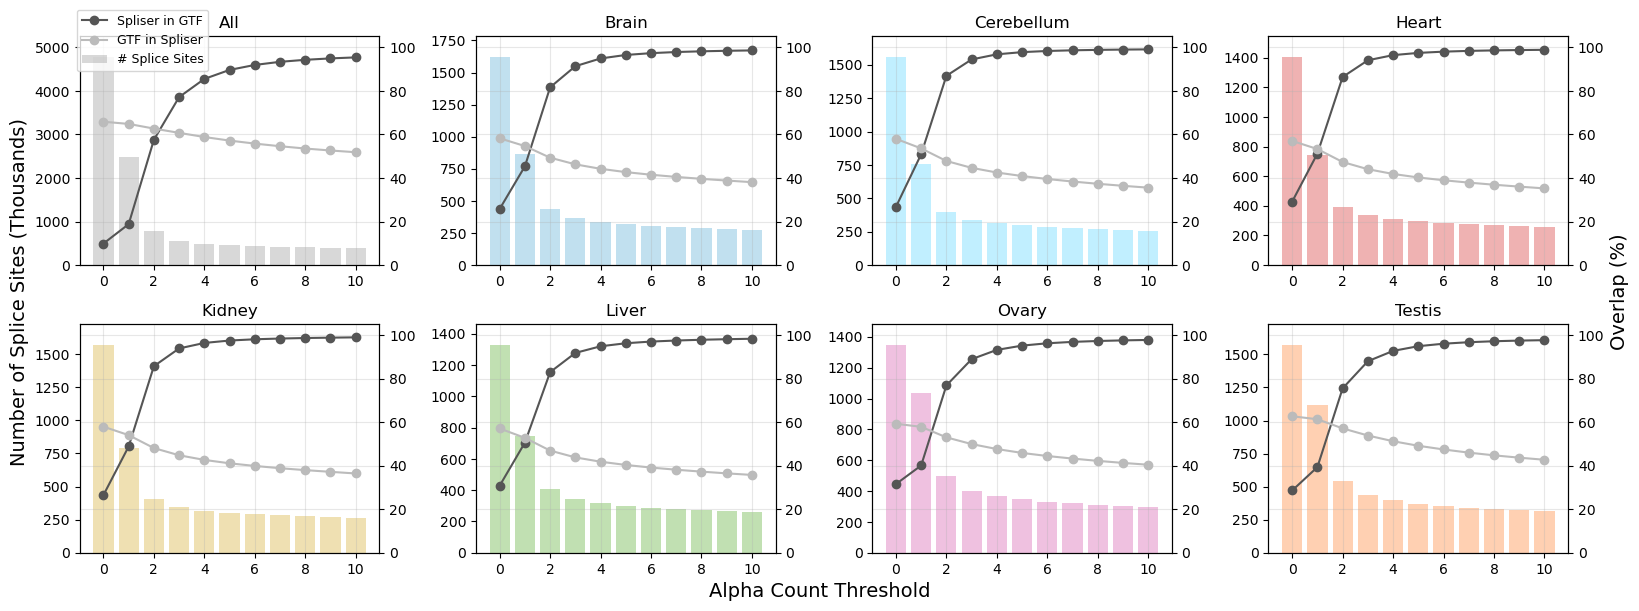

In [20]:
import numpy as np
import matplotlib.pyplot as plt

n_tissues = ovl_df['Tissue'].nunique()
nrows = 2
ncols = int(np.ceil(n_tissues / nrows))
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharey=False)
axes = axes.flatten()

gray1 = '#555555'
gray2 = '#bbbbbb'

for ax, (tissue_name, tissue_df) in zip(axes, ovl_df.groupby('Tissue')):
    color = tissue_colors.get(tissue_name, 'tab:gray')
    bars = ax.bar(
        tissue_df['Alpha Count Threshold'],
        tissue_df['Number of Splice Sites'] / 1000,
        color=color, alpha=0.3, width=0.8, label='Number of Splice Sites'
    )
    ax.set_ylim(0, (tissue_df['Number of Splice Sites'] / 1000).max() * 1.1)
    ax.grid(axis='x', alpha=0.3)
    ax.set_title(tissue_name, fontsize=12)

    ax2 = ax.twinx()
    ax2.grid(True, alpha=0.3)
    line1, = ax2.plot(
        tissue_df['Alpha Count Threshold'],
        tissue_df['Overlap Spliser to Annotation (%)'],
        color=gray1, marker='o', label='Spliser to Annotation'
    )
    line2, = ax2.plot(
        tissue_df['Alpha Count Threshold'],
        tissue_df['Overlap Annotation to Spliser (%)'],
        color=gray2, marker='o', label='Annotation to Spliser'
    )
    ax2.set_ylim(0, 105)
    if tissue_name == 'All':
        ax2.legend(
            [line1, line2, bars], 
            ['Spliser in GTF', 'GTF in Spliser', '# Splice Sites'], 
            bbox_to_anchor=(0.45, 0.82), ncol=1,
            fontsize=9)

# Hide unused axes if n_tissues is odd
for ax in axes[n_tissues:]:
    ax.set_visible(False)

plt.tight_layout()

# Shared axis labels
fig.text(0.5, 0, 'Alpha Count Threshold', ha='center', va='center', fontsize=14)
fig.text(0, 0.5, 'Number of Splice Sites (Thousands)', ha='center', va='center', rotation='vertical', fontsize=14)
fig.text(1, 0.5, 'Overlap (%)', ha='center', va='center', rotation='vertical', fontsize=14)

plt.savefig('plots/splice_site_annotation_overlap.pdf', bbox_inches='tight')
plt.show()


Nonoverlapping splice sites in SpliSER (i.e. splice sites unannotated in GTF).

In [ ]:
# Get non-overlapping splice sites from SpliSER
novl_spl_ann = pd.merge(spliser_df, splices_df, on=['chrom', 'site'], how='left', indicator=True)
novl_spl_ann = novl_spl_ann[novl_spl_ann['_merge'] == 'left_only'].drop(columns=['_merge'])

# Filter for alpha_count >= 5
alpha_thrs = 5
novl_spl_ann = novl_spl_ann[novl_spl_ann['alpha_count'] >= alpha_thrs]

# Count
num_novl_sites = novl_spl_ann.drop_duplicates(subset=['chrom', 'site']).shape[0]
print(f"{num_novl_sites} splice sites with alpha_count >= {alpha_thrs} are not annotated intron boundaries.")

For each unannotated splice site, how many tissues and timepoints is it found in?

In [141]:
novl_site_info = novl_spl_ann.groupby(['chrom', 'site', 'tissue']).agg(
    num_timepoints=pd.NamedAgg(column='timepoint', aggfunc=lambda x: x.nunique())
).reset_index()

novl_site_info = novl_site_info.groupby(['chrom', 'site']).agg(
    tissues=pd.NamedAgg(column='tissue', aggfunc=lambda x: list(x.unique())),
    num_tissues=pd.NamedAgg(column='tissue', aggfunc=lambda x: x.nunique()),
    num_tissue_timepoints=pd.NamedAgg(column='num_timepoints', aggfunc=lambda x: list(x)),
).reset_index()

novl_site_info

,chrom,site,tissues,num_tissues,num_tissue_timepoints
0,1,11212,"[Ovary, Testis]",2,"[1, 1]"
1,1,12009,"[Ovary, Testis]",2,"[2, 2]"
2,1,12698,[Testis],1,[1]
3,1,12722,"[Ovary, Testis]",2,"[2, 1]"
4,1,13220,[Testis],1,[1]
...,...,...,...,...,...
48677,Y,59355972,"[Brain, Cerebellum, Heart, Kidney, Ovary, Testis]",6,"[1, 1, 1, 1, 3, 2]"
48678,Y,59356944,"[Brain, Cerebellum, Heart, Kidney, Liver, Ovar...",7,"[5, 5, 4, 7, 7, 8, 9]"
48679,Y,59357702,"[Brain, Cerebellum, Heart, Kidney, Liver, Ovar...",7,"[5, 5, 4, 7, 7, 8, 9]"
48680,Y,59357772,"[Brain, Cerebellum, Liver, Testis]",4,"[1, 1, 1, 3]"


/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are sett

<Figure size 1000x600 with 0 Axes>

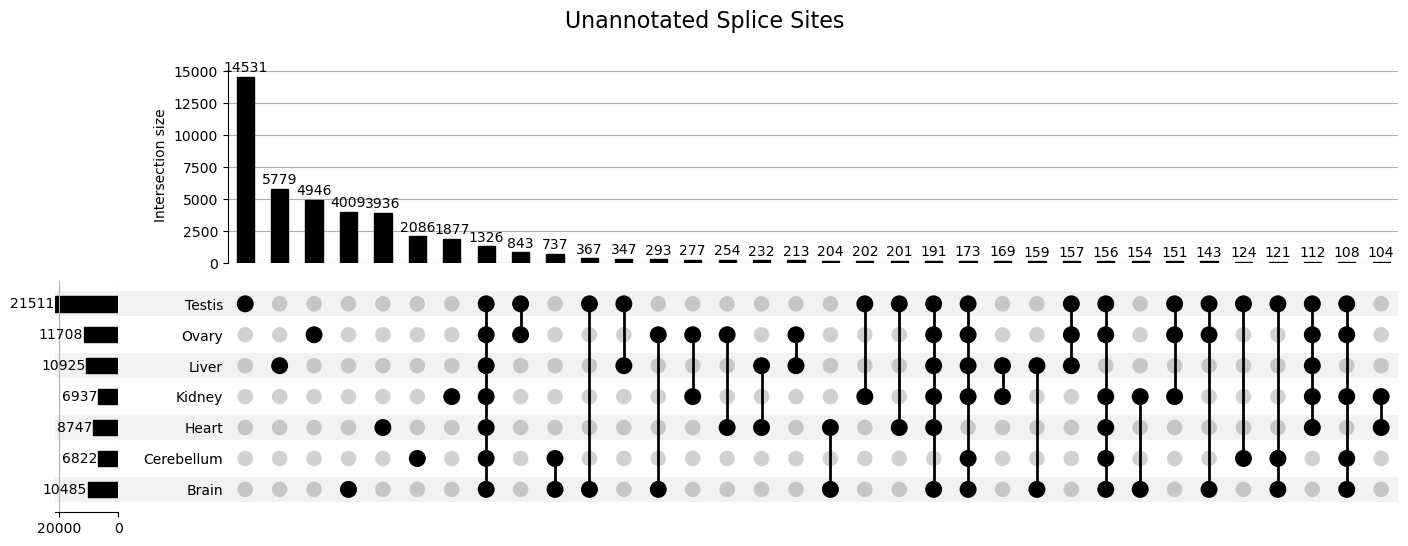

In [95]:
# Plot upset plot of sites found in multiple tissues (include only overlaps where there are more than 500 sites in the intersection)
from upsetplot import UpSet, from_indicators

# Create boolean columns for each tissue
novl_spl_ann_bool = novl_spl_ann[['chrom','site','tissue']].drop_duplicates().copy()
novl_spl_ann_bool.sort_values(by=['chrom', 'site'], inplace=True)

# Pivot to get boolean indicators for each tissue
novl_spl_ann_bool['value'] = True
novl_spl_ann_bool = novl_spl_ann_bool.pivot_table(index=['chrom', 'site'], columns='tissue', values='value', fill_value=False)
novl_spl_ann_bool = novl_spl_ann_bool.astype(bool)

# Create upset dataframe
upset_data = from_indicators(novl_spl_ann['tissue'].unique(), novl_spl_ann_bool)

# Plot
upset = UpSet(upset_data, subset_size='count', show_counts='%d', min_subset_size=100, sort_by='cardinality', sort_categories_by=None)
plt.figure(figsize=(10,6))
upset.plot()
plt.suptitle(f'Unannotated Splice Sites', fontsize=16)
plt.savefig('plots/splice_sites_unannotated_in_tissues.pdf', bbox_inches='tight')
plt.show()

For the tissue-specific unannotted splice sites, how many timepoints is each site found in?

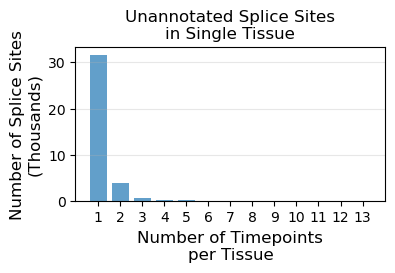

In [156]:
import collections

novl_site_info_1 = novl_site_info[novl_site_info['num_tissues'] == 1]

# Flatten the list of timepoints
vals = novl_site_info_1['num_tissue_timepoints'].values
flat_counts = [item for sublist in vals for item in sublist]
counter = collections.Counter(flat_counts)

# Sort by timepoint
timepoints = sorted(counter.keys())

# Plot barplot of number of timepoints for sites found in single tissue
plt.figure(figsize=(4,2))
counts = [counter[tp]/1000 for tp in timepoints]
bars = plt.bar(timepoints, counts, color='tab:blue', alpha=0.7)
plt.xlabel('Number of Timepoints\nper Tissue', fontsize=12)
plt.ylabel('Number of Splice Sites\n(Thousands)', fontsize=12)
plt.title(f'Unannotated Splice Sites\nin Single Tissue', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(timepoints)
plt.savefig('plots/splice_sites_unannotated_single_tissue_timepoints.pdf', bbox_inches='tight')
plt.show()

For the unannotted splice sites shared in all tissues, how many timepoints is each site found in?

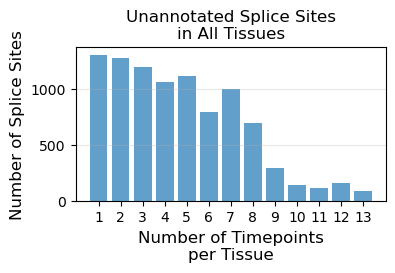

In [157]:
novl_site_info_all = novl_site_info[novl_site_info['num_tissues'] == max(novl_site_info['num_tissues'])]

# Flatten the list of timepoints
vals = novl_site_info_all['num_tissue_timepoints'].values
flat_counts = [item for sublist in vals for item in sublist]
counter = collections.Counter(flat_counts)

# Sort by timepoint
timepoints = sorted(counter.keys())

# Plot barplot of number of timepoints for sites found in single tissue
plt.figure(figsize=(4,2))
counts = [counter[tp] for tp in timepoints]
bars = plt.bar(timepoints, counts, color='tab:blue', alpha=0.7)
plt.xlabel('Number of Timepoints\nper Tissue', fontsize=12)
plt.ylabel('Number of Splice Sites', fontsize=12)
plt.title(f'Unannotated Splice Sites\nin All Tissues', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(timepoints)
plt.savefig('plots/splice_sites_unannotated_all_tissues_timepoints.pdf', bbox_inches='tight')
plt.show()

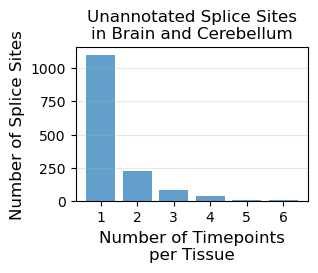

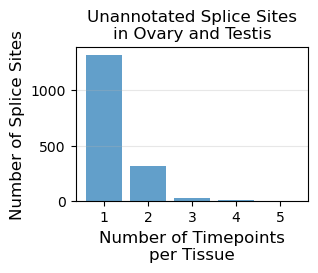

In [158]:
# Get splice sites in pairs of tissues: 
for pair in [('Brain', 'Cerebellum'), ('Ovary', 'Testis')]:

    # Subset where tissues match the pair
    novl_site_info_pair = novl_site_info[novl_site_info['tissues'].apply(lambda x: sorted(x) == sorted(list(pair)))]

    # Plot barplot of number of timepoints per tissue
    import collections

    plt.figure(figsize=(3,2))
    # Flatten the list of timepoints
    vals = novl_site_info_pair['num_tissue_timepoints'].values
    flat_counts = [item for sublist in vals for item in sublist]
    counter = collections.Counter(flat_counts)
    # Sort by timepoint
    timepoints = sorted(counter.keys())
    counts = [counter[tp] for tp in timepoints]
    bars = plt.bar(timepoints, counts, color='tab:blue', alpha=0.7)
    plt.xlabel('Number of Timepoints\nper Tissue', fontsize=12)
    plt.ylabel('Number of Splice Sites', fontsize=12)
    plt.title(f'Unannotated Splice Sites\nin {pair[0]} and {pair[1]}', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.xticks(timepoints)
    plt.savefig(f'plots/splice_sites_unannotated_{pair[0].lower()}_{pair[1].lower()}_timepoints.pdf', bbox_inches='tight')
    plt.show()

For unannotated splice sites shared between Brain and Cerebellum, do they change in coordinated manner across timepoints?

***

In [76]:
from tqdm import tqdm

count_exonic = 0
count_intronic = 0
count_intergenic = 0
distances = {
    'exonic': [],
    'intronic': [],
    'intergenic': []
}

# what genomic regions are these non-overlapping sites located in?
exon_df = gtf_df[gtf_df['feature'] == 'exon']
transcript_df = gtf_df[gtf_df['feature'] == 'transcript']

for index in tqdm(range(1000), desc="Processing splice sites", unit="site"):
#for index in tqdm(range(novl_spl_ann.shape[0]), desc="Processing splice sites", unit="site"):
    row = novl_spl_ann.iloc[index]
    edf = exon_df[exon_df['chrom'] == row['chrom']]
    tdf = transcript_df[transcript_df['chrom'] == row['chrom']]

    # is row in transcript?
    transcript_ovl = tdf[ 
        (tdf['start'] <= row['site']) & 
        (tdf['end'] >= row['site'])]
    transcript_ovl = transcript_ovl.drop_duplicates(subset=['chrom', 'gene_id'])
    if transcript_ovl.shape[0] == 0:
        count_intergenic += 1
        # distance to nearest transcript start or end
        dist_to_starts = abs(tdf['start'] - row['site'])
        dist_to_ends = abs(tdf['end'] - row['site'])
        min_dist = min(dist_to_starts.min(), dist_to_ends.min())
        distances['intergenic'].append(min_dist)
    else:
        # is row in exon?
        exon_ovl = edf[
            (edf['start'] <= row['site']) &
            (edf['end'] >= row['site'])
        ]
        if exon_ovl.shape[0] == 0:
            count_intronic += 1
            # distance to nearest transcript start or end
            dist_to_starts = abs(transcript_ovl['start'] - row['site'])
            dist_to_ends = abs(transcript_ovl['end'] - row['site'])
            min_dist = min(dist_to_starts.min(), dist_to_ends.min())
            distances['intronic'].append(min_dist)
        else:
            count_exonic += 1
            # distance to nearest exon start or end
            dist_to_starts = abs(exon_ovl['start'] - row['site'])
            dist_to_ends = abs(exon_ovl['end'] - row['site'])
            min_dist = min(dist_to_starts.min(), dist_to_ends.min())
            distances['exonic'].append(min_dist)

print(f"Exonic: {count_exonic}, Intronic: {count_intronic}, Intergenic: {count_intergenic}")
print(f"Mean distances - Exonic: {sum(distances['exonic']) / len(distances['exonic']) if len(distances['exonic']) > 0 else 'N/A'}, Intronic: {sum(distances['intronic']) / len(distances['intronic']) if len(distances['intronic']) > 0 else 'N/A'}, Intergenic: {sum(distances['intergenic']) / len(distances['intergenic']) if len(distances['intergenic']) > 0 else 'N/A'}")


Processing splice sites: 100%|██████████| 1000/1000 [05:32<00:00,  3.01site/s]

Exonic: 586, Intronic: 404, Intergenic: 10
Mean distances - Exonic: 191.58703071672355, Intronic: 28722.02475247525, Intergenic: 5851.1
